# Image Processing in Python

## Introduction

Yesterday, we gave a brief overview of Python and three powerful libraries we will be using to develop for DeepCell. Today, we will become more familiar with SciPy and in particular the `scikit-image` package as we review the basics of image processing using Python. <i> NB: scikit-image has a description of tag `skimage` that can be used interchageably with the offical name.</i>

In this tutorial, we will cover:

* Loading & Handling Image Data: Input/output, Data Types, and Colorspaces
* Preprocessing: Contrast Adjustment, Background Subtraction, and Filtering 
* Foreground Detection: Thresholding and Morphological Operations
* Object Detection and Segmentation: Labeling, Seeding and Expansion
* Postprocessing: Affine Transformations
* Writing Output to Files: Images, JSON, and NPZ

## Loading and Handling Image Data

`skimage` has a number of useful functions we can import to load and manipulate images, as well as save the resulting images. Remember, though, this library builds on NumPy, so we will need to import that library as well.

In [ ]:
%matplotlib inline

import numpy as np

from skimage.io import imread, imsave, imshow
from skimage.transform import resize as imresize

# Read an JPEG image into a numpy array
#img = imread('resources/img_000000000_Phase_000.png')
img = imread('resources/cat.jpg')
print(img.dtype, img.shape)  # Prints "uint8 (400, 248, 3)"

# We can tint the image by scaling each of the color channels
# by a different scalar constant. The image has shape (400, 248, 3);
# we multiply it by the array [1, 0.95, 0.9] of shape (3,);
# numpy broadcasting means that this leaves the red channel unchanged,
# and multiplies the green and blue channels by 0.95 and 0.9
# respectively.
img_tinted = img * [1, 0.95, 0.9]

# Resize the tinted image to be 300 by 300 pixels.
img_tinted = imresize(img_tinted, (300, 300))

# Write the tinted image back to disk
imsave('resources/cat_tinted.jpg', np.uint8(img_tinted))


Rather than "hardcoding" the file path, a more robust way of handling these operations is to designate a section of code to specify the directory path and file name as variables. 

If the file is not in the current working directory, you must also have a way of specifying the path to the directory where the file is stored. In our case, the example images are stored in the directory called 'resources' in the same folder as this notebook. Note that you can use either the full path - something like r"/home/user/bootcamp/intro-to-deepcell/resources/example_cells_1.tif" or the relative path, starting from the current working directory.

NB: Paths and filenames can contain slashes, empty spaces and other special symbols, which can cause trouble for programming languages under certain circumstances. To circumvent such trouble, add the letter r before your string definition to create a so-called 'raw string', which is not affected by these problems (e.g. `my_raw_string = r"some string with funny symbols: \\\!/~***!"`).

In [ ]:
# Create a string variable with the name of the file you'd like to load (here: 'example_cells_1.tif').
# Suggested name for the variable: filename
filename = r'img_000000000_FITC_001.png'

# Create a string variable with the path to the directory that contains the file you'd like to load.
# Suggested name for the variable: dirpath
dirpath = r'resources'  # Relative path
#dirpath = r'/home/user/bootcamp/intro-to-deepcell/resources/img_000000000_FITC_001.png'  # Absolute path 

In [ ]:
# Now combine the directory path and file name into one variable, the file path

# Import the function 'join' from the module 'os.path'
# This function automatically takes care of the slashes that need to be added when combining two paths.
from os.path import join

# Print the result to see that everything is correct
# Suggested name for the variable: filepath
filepath = join(dirpath, filename)
print(filepath)

With the file path established, we can load the image (using the `imread` function we imported earlier), make sure the load was successful, and display the image.

In [ ]:
# Load 'img_000000000_Far-red_001.png' and store it in a variable.
# Suggested name for the variable: img
img = imread(filepath)

In [ ]:
# Check that the load went as expected

# Check that 'img' is a variable of type 'ndarray' - use Python's built-in function 'type'.
print("Loaded array is of type:", type(img))

# Print the shape of the array using the numpy-function 'shape'. 
print("Loaded array has shape:", img.shape)

# Check the datatype of the individual numbers in the array. You can use the array attribute 'dtype' to do so.
print("Loaded values are of type:", img.dtype)

NB: The dtype should be 'uint16', because these are unsigned 16-bit integer images. Another common dtype for images is uint8. You can read more about the differences [here](https://www.mathworks.com/help/matlab/creating_plots/working-with-8-bit-and-16-bit-images.html) and [here](https://printaura.com/8-bit-vs-16-bit-images-whats-the-difference-which-to-use/)

Now we're ready to take a look at the images. To plot the array as an image, use pyplot's functions `plt.imshow` followed by `plt.show`. 

You can check the documentation for `plt.imshow` and note the parameters that can be specified, such as colormap (cmap)
and interpolation. Since we are working with scientific data, interpolation is unwelcome, so you should set it to "none". The most common cmap for grayscale images is naturally "gray". You may also want to adjust the size of the figure. You can do this by preparing the figure canvas with the function `plt.figure` before calling `plt.imshow`. The canvas size is adjusted using the keyword argument 'figsize' when calling `plt.figure`.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.imshow(img, interpolation='none', cmap='gray')
plt.show()

Don't worry if it's dark, we'll fix that in a minute. In the meantime, for our peace of mind, here is a side-by-side example using our cat image from ealier:

In [ ]:
img2 = imread('resources/cat.jpg')
img_tinted2 = img2 * [1, 0.95, 0.9]

# Show the original image
plt.subplot(1, 2, 1)
plt.imshow(img2)

# Show the tinted image
plt.subplot(1, 2, 2)

# A slight gotcha with imshow is that it might give strange results if presented with data that is not uint8. 
# To work around this, we explicitly cast the image to uint8 before displaying it.
plt.imshow(np.uint8(img_tinted2))
plt.show()

## Preprocessing

Raw microscope images, like the ones we will be using to train our neural nets, often start out looking like garbage. Viz.:
![alt text][phase000]

[phase000]: ./resources/img_000000000_Phase_000.png "A Bunch of Cells?"

Before we can really use this image for anything, we need to improve it. This is the (pre)process of preprocessing.

### Contrast Adjustment

One common preprocessing operation is to tweak the image's contrast.

Within `skimage`, there are multiple functions inside the `skimage.exposure` module that relate to contrast adjustment. We will highlight a few of them here:

* `skimage.exposure.histogram`
* `skimage.exposure.equalize_hist`
* `skimage.exposure.equalize_adapthist`
* `skimage.exposure.rescale_intensity`
* `skimage.exposure.adjust_gamma`


#### `skimage.exposure.histogram`

Let's use `skimage.exposure.histogram` to view the distribution of pixel intensities in cat image.

Note the use of indices on the cat image. It's often most informative to look at each channel in a color image separately, which is what we're doing here.

In [ ]:
from skimage.exposure import histogram

# compute histogram in Red channel of cat image
(counts, bins) = histogram(img2[:,:,0])
# view histogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(bins,counts)

Very cool.

Now, let's look at our cell image.

In [ ]:
# compute histogram
phase_image = imread("resources/img_000000000_Phase_000.png")
(counts, bins) = histogram(phase_image)
# view histogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter( bins, counts)

What...?

Why is this histogram different from the previous one?

#### skimage.exposure.equalize_hist

Let's use `skimage.exposure.equalize_hist` to change the histogram of the phase_image. This function changes the pixel intensity values in the image by spreading them out as evenly as possible across the pixel intensity range while still preserving relative intensities.

In [ ]:
from skimage.exposure import equalize_hist

# compute histogram
equalized_image = equalize_hist(phase_image)

plt.rcParams['figure.figsize'] = [16,8]
plt.figure()
plt.subplot(1,2,1)
plt.imshow(equalized_image, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(phase_image, cmap='gray')

If we compare these two images' histograms side by side:

In [ ]:
# compute histograms
(counts_phase, bins_phase) = histogram(phase_image)
(counts_equalized, bins_equalized) = histogram(equalized_image)
# view histograms
plt.rcParams['figure.figsize'] = [10,5]
plt.figure()
plt.subplot(1,2,1)
plt.scatter(bins_phase,counts_phase)
plt.subplot(1,2,2)
plt.scatter(bins_equalized,counts_equalized)
(equalized_image.dtype, equalized_image.min(), equalized_image.max())

We see that the distribution of the pixels has been dramatically transformed! Not only have we moved from a uint16 pixel encoding to some sort of float encoding (probably float64), but we've also redistributed our pixels so that they are spread all across the available pixel value range.

In [ ]:
# compute histograms
(counts_phase, bins_phase) = histogram(phase_image)
(counts_equalized, bins_equalized) = histogram(equalized_image)

# compute cumulative distribution functions
img_cdf_phase, bins_phase = exposure.cumulative_distribution(phase_image, 256)
img_cdf_phase = img_cdf_phase
img_cdf_equalized, bins_equalized = exposure.cumulative_distribution(equalized_image, 256)
img_cdf_equalized = img_cdf_equalized

# view histograms
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,8) )

## left plot
right_y_axis_0 = axes[0].twinx()
axes[0].scatter(bins_phase,counts_phase)
#axes[0].plot(bins_phase, img_cdf_phase, 'r')
right_y_axis_0.set_ylim(0,1)
right_y_axis_0.plot(bins_phase, img_cdf_phase, 'r')

## right plot
right_y_axis_1 = axes[1].twinx()
axes[1].scatter(bins_equalized,counts_equalized)
axes[1].set_ylim(4000,7000)
right_y_axis_1.set_ylim(0,1)
right_y_axis_1.plot(bins_equalized, img_cdf_equalized, 'r')

What's more, we've actually transformed the cumulative distribution function (CDF) of pixel values so that hte pixels are now optimally spaced across the entire pixel value range. This maximizes the global contrast of the image, which generally makes things easier to see.

To read more about the math of histogram equalization (which is pleasantly intuitive), visit  
https://en.wikipedia.org/wiki/Histogram_equalization

#### `skimage.exposure.equalize_adapthist`

As an alternative to `skimage.exposure.equalize_hist`, we can use `skimage.exposure.equalize_adapthist`, which performs the same process of spreading pixel intensity values evenly over the available range. However, whereas `skimage.exposure.equalize_hist` does this for the entire image at once, `skimage.exposure.equalize_adapthist` looks at each pixel within the context of a local neighborhood only. (By default, the neighborhoods are 1/8x1/8 of the image. This neighborhood size can be changed by setting the `kernal_size` argument in `skimage.exposure.equalize_adapthist` to the desired pixel value of the neighborhood. Give it a try.)

`skimage.exposure.equalize_adapthist`'s main advantage over `skimage.exposure.equalize_hist` is that `skimage.exposure.equalize_adapthist` can adjust contrast locally, thus potentially giving better definition to a wider range of features from across the image.

In [ ]:
from skimage.exposure import equalize_adapthist

# compute histogram
equalized_adapted_image = equalize_adapthist(phase_image, kernel_size=None)

plt.rcParams['figure.figsize'] = [16,8]
plt.figure()
plt.subplot(1,2,1)
plt.title("original phase image")
plt.imshow(phase_image, cmap='gray')
plt.subplot(1,2,2)
plt.title("equalized_adapted_image")
plt.imshow(equalized_adapted_image, cmap='gray')

Comparing the original histogram with the histogram resulting from `skimage.exposure.equalize_adapthist`:

In [ ]:
# compute histograms
(counts_phase, bins_phase) = histogram(phase_image)
(counts_equalized, bins_equalized) = histogram(equalized_adapted_image)

# compute cumulative distribution functions
img_cdf_phase, bins_phase = exposure.cumulative_distribution(phase_image, 256)
img_cdf_phase = img_cdf_phase
img_cdf_equalized, bins_equalized = exposure.cumulative_distribution(equalized_adapted_image, 256)
img_cdf_equalized = img_cdf_equalized

# view histograms
fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(16,8) )

## left plot
right_y_axis_0 = axes[0].twinx()
axes[0].scatter(bins_phase,counts_phase)
#axes[0].plot(bins_phase, img_cdf_phase, 'r')
right_y_axis_0.set_ylim(0,1)
right_y_axis_0.plot(bins_phase, img_cdf_phase, 'r')

## right plot
right_y_axis_1 = axes[1].twinx()
axes[1].scatter(bins_equalized,counts_equalized)
#axes[1].set_ylim(4000,7000)
right_y_axis_1.set_ylim(0,1)
right_y_axis_1.plot(bins_equalized, img_cdf_equalized, 'r')

The net result of `skimage.exposure.equalize_adapthist` is to spread out really common pixel values somewhat, thereby increasing contrast among common pixel values, but not dramatically altering many values.

Mathematical details can be found here:
https://en.wikipedia.org/wiki/CLAHE

#### `skimage.exposure.rescale_intensity`

#### `skimage.exposure.adjust_gamma`

Contrast adjustment is the process of remapping pixel intensity values in an image such that, generally, there is a broader range of lights and darks, making objects in the image more discernible.

In the example above, the child and lattice work in the left image are visible but, after contrast adjusted right image, they are much more readily visible.

To make the process more quantitative (and, thus, amenable to algorithms), we often refer to the histogram of pixel intensities in an image. Histograms for both images are included above. Note the much wider spread of values in the right histogram, with the pixel values occupying the entire avaiable range.

Although not present on the histograms above, we will often overlay our histograms with cumulative distribution functions (CDF), which provide another quantitatively-motivated way of visualizing our pixel distributions. Don't worry if you know nothing about cumulative distribution functions; we'll be able to talk about them when they come up.

(**Bonus question**: can anyone tell what data type these images are encoded as, assuming their histograms are showing the entire range of possible pixel values? I.e., if we were to check the `.dtype` of these images, what would we see?)

Within `skimage`, there are multiple functions inside the `skimage.exposure` module for contrast adjustment and histogram observation. We will highlight a few of them here:

* `skimage.exposure.histogram`
* `skimage.exposure.equalize_hist`
* `skimage.exposure.equalize_adapthist`
* `skimage.exposure.rescale_intensity`
* `skimage.exposure.adjust_gamma`


In [ ]:
#### **`skimage.exposure.histogram`**

Let's use `skimage.exposure.histogram` to view the distribution of pixel intensities in the cat image.

Note the use of indices on the cat image. It's often most informative to look at each channel in a color image separately, which is what we're doing here.

In [ ]:
from skimage.exposure import histogram

# compute histogram in Red channel of cat image
(counts, bins) = histogram(img2[:,:,0])
# view histogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(bins,counts)

In [ ]:
Very cool. What do you all see here?

Now, let's look at our cell image.

In [ ]:
# compute cell histogram
#phase_image = imread("resources/img_000000000_Phase_000.png")
#phase_image_float = phase_image/phase_image.max()
#(counts, bins) = histogram(phase_image_float)

(counts, bins) = histogram(img)
# view cell histogram
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter( bins, counts)

In [ ]:
We can see that we have a lot of pixels with intermediate values and few (none?) the further we go out to the extremes.

#### **`skimage.exposure.rescale_intensity`**

A really basic way to adjust the contrast of an image is to stretch the min and max values found in the image to the smallest and 
largest possible intensity values, respectively, and then spread out all the intermediate values accordingly. That's what `skimage.exposure.rescale_intensity` does.

In [ ]:
# First check the cell image's min and max values
print( "Minimum pixel value: ", img.min())
print( "Maximum pixel value: ", img.max())

# Also, check its dtype attribute to understand what its range of values is.
print( "Data type of image: ", img.dtype)

Now it's calculation time. Whoo!

We can see, from looking at the data type of the image, that the minimum and maximum possible pixel values are _____ and _____, respectively.

Since the observed pixel values run from 71 to 12342, we can see that our image is currently using a pixel intensity range of (12342 - 71 = 12271), which is _____% of the maximum possible intensity range of ______.

This tells us that, if we just rescale the min and max values of the image to the max and min of their possible range, we will see a _____-fold increase in the pixel intensity range of the image.

Let's see how much that helps now.

In [ ]:
from skimage.exposure import rescale_intensity

# Rename initial cell image for conceptual clarity
img_fitc = img

#img_fitc = (((img_fitc-img_fitc.min())/(img_fitc.max()-img_fitc.min()))*255).astype(np.uint8)

# adjust image contrast by rescaling pixel values
img_rescaled = rescale_intensity(img_fitc)

# compute histograms
(counts_fitc, bins_fitc) = histogram(img_fitc)
(counts_rescaled, bins_rescaled) = histogram(img_rescaled)

# compute cumulative distribution functions
img_cdf_fitc, bins_fitc = exposure.cumulative_distribution(img_fitc, 256)
img_cdf_fitc = img_cdf_fitc
img_cdf_rescaled, bins_rescaled = exposure.cumulative_distribution(img_rescaled, 256)
img_cdf_rescaled = img_cdf_rescaled

# view images and histograms
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,16) )

## original image
axes[0,0].imshow(img_fitc, cmap='gray')

## rescaled image
axes[0,1].imshow(img_rescaled, cmap='gray')

## original histogram and cdf
right_y_axis_0 = axes[1,0].twinx()
axes[1,0].scatter(bins_fitc,counts_fitc)
right_y_axis_0.set_ylim(0,1)
right_y_axis_0.plot(bins_fitc, img_cdf_fitc, 'r')

## rescaled histogram and cdf
right_y_axis_1 = axes[1,1].twinx()
axes[1,1].scatter(bins_rescaled,counts_rescaled)
right_y_axis_1.set_ylim(0,1)
right_y_axis_1.plot(bins_rescaled, img_cdf_rescaled, 'r')

Any thoughts?

What do we see if we look at the `min()` and `max()` of the rescaled image?

How useful is this technique for this particular image?

#### **`skimage.exposure.equalize_hist`**

Now, let's try a more sophisticated technique for contrast adjustment.

Let's use `skimage.exposure.equalize_hist` to not only spread the range of pixel intensities out to its max, but to then move pixel values around so that the pixels more or less evenly occupy every possible value across this range. We won't be changing the relative intensities of any two pixels (if one pixel has a higher value than another before contrast adjustment, it will still have a higher value after), but we will be moving their absolute values around with that constraint in place.

In [ ]:
from skimage.exposure import equalize_hist

# adjust image contrast by equalizing the histogram
img_equalized = equalize_hist(img_fitc)

# compute histograms
(counts_fitc, bins_fitc) = histogram(img_fitc)
(counts_equalized, bins_equalized) = histogram(img_equalized)

# compute cumulative distribution functions
img_cdf_fitc, bins_fitc = exposure.cumulative_distribution(img_fitc, 256)
img_cdf_fitc = img_cdf_fitc
img_cdf_equalized, bins_equalized = exposure.cumulative_distribution(img_equalized, 256)
img_cdf_equalized = img_cdf_equalized

# view images and histograms
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,16) )

## original image
axes[0,0].imshow(img_fitc, cmap='gray')

## rescaled image
axes[0,1].imshow(img_equalized, cmap='gray')

## original histogram and cdf
right_y_axis_0 = axes[1,0].twinx()
axes[1,0].scatter(bins_fitc,counts_fitc)
right_y_axis_0.set_ylim(0,1)
right_y_axis_0.plot(bins_fitc, img_cdf_fitc, 'r')

## rescaled histogram and cdf
right_y_axis_1 = axes[1,1].twinx()
axes[1,1].scatter(bins_equalized,counts_equalized)
right_y_axis_1.set_ylim(0,1)
right_y_axis_1.plot(bins_equalized, img_cdf_equalized, 'r')

Note that we have we moved from a uint16 pixel encoding to some sort of float encoding (probably float64) in the right image, due to the way `skimage.exposure.equalize_hist` operates. How can we tell that our data type has changed?

Now, if we compare these two images' histograms, we see that the distribution of the pixels has been dramatically transformed!

What have we done here? Let's discuss it.

The net takeaway is that we've transformed the cumulative distribution function (CDF) of pixel values so that the pixels are now optimally spaced across the entire pixel intensity range. This maximizes the global contrast of the image, which generally makes things easier to see.

To read more about the math of histogram equalization (which is pleasantly intuitive, compared to a lot of other stuff), visit  
https://en.wikipedia.org/wiki/Histogram_equalization

#### **`skimage.exposure.equalize_adapthist`**

As a more robust alternative to `skimage.exposure.equalize_hist`, we can use `skimage.exposure.equalize_adapthist`, which performs the same process of spreading pixel intensity values evenly over the available range and then remapping them to smooth out the histogram. However, whereas `skimage.exposure.equalize_hist` does this for the entire image at once, `skimage.exposure.equalize_adapthist` looks at each pixel within the context of that pixel's local neighborhood only. This is particularly useful for images with strong global contrasts between lights and darks across the entire image, but minimal local contrasts between lights and darks.

(By default, the neighborhoods are 1/8x1/8 of the image. This neighborhood size can be changed by setting the `kernel_size` argument in `skimage.exposure.equalize_adapthist` to the desired pixel value of the neighborhood. Give it a try.)

In [ ]:
from skimage.exposure import equalize_adapthist

# adjust image contrast by adaptively equalizing the histogram
img_equalized_adapted = equalize_adapthist(img_fitc, kernel_size=None)

# compute histograms
(counts_fitc, bins_fitc) = histogram(img_fitc)
(counts_equalized_adapted, bins_equalized_adapted) = histogram(img_equalized_adapted)

# compute cumulative distribution functions
img_cdf_fitc, bins_fitc = exposure.cumulative_distribution(img_fitc, 256)
img_cdf_fitc = img_cdf_fitc
img_cdf_equalized_adapted, bins_equalized_adapted = exposure.cumulative_distribution(img_equalized_adapted, 256)
img_cdf_equalized_adapted = img_cdf_equalized_adapted

# view images and histograms
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,16) )

## original image
axes[0,0].imshow(img_fitc, cmap='gray')

## rescaled image
axes[0,1].imshow(img_equalized_adapted, cmap='gray')

## original histogram and cdf
right_y_axis_0 = axes[1,0].twinx()
axes[1,0].scatter(bins_fitc,counts_fitc)
right_y_axis_0.set_ylim(0,1)
right_y_axis_0.plot(bins_fitc, img_cdf_fitc, 'r')

## rescaled histogram and cdf
right_y_axis_1 = axes[1,1].twinx()
axes[1,1].scatter(bins_equalized_adapted,counts_equalized_adapted)
right_y_axis_1.set_ylim(0,1)
right_y_axis_1.plot(bins_equalized_adapted, img_cdf_equalized_adapted, 'r')

In [ ]:
The net result of `skimage.exposure.equalize_adapthist` is to spread out really common pixel values somewhat, thereby increasing contrast among common pixel values, but not dramatically altering many values.

Mathematical details can be found here:
https://en.wikipedia.org/wiki/CLAHE

#### **`skimage.exposure.adjust_gamma`**

`skimage.exposure.adjust_gamma` spread pixel intensities out, like all the other contrast adjustment algorithms. After that, though, it normalizes all the pixel values so that they range from 0 to 1 (like it appears that the other `skimage` contrast adjustment functions are doing) and performs Gamme Correction, which just raises every pixel value to a certain exponent. Note that often this exponent is less than one. Since we normalized pixel values ahead of time, this transform doesn't cause us to sacrifice any of our pixel intensity range, which is part of what makes it appealing.

In [ ]:
from skimage.exposure import adjust_gamma

# adjust image contrast according to the Gamma Correction algorithm
img_gamma = adjust_gamma(img_fitc, gamma=1, gain=1)

# compute histograms
(counts_fitc, bins_fitc) = histogram(img_fitc)
(counts_gamma, bins_gamma) = histogram(img_gamma)

# compute cumulative distribution functions
img_cdf_fitc, bins_fitc = exposure.cumulative_distribution(img_fitc, 256)
img_cdf_fitc = img_cdf_fitc
img_cdf_gamma, bins_gamma = exposure.cumulative_distribution(img_gamma, 256)
img_cdf_gamma = img_cdf_gamma

# view images and histograms
fig, axes = plt.subplots( nrows=2, ncols=2, figsize=(16,16) )

## original image
axes[0,0].imshow(img_fitc, cmap='gray')

## rescaled image
axes[0,1].imshow(img_gamma, cmap='gray')

## original histogram and cdf
right_y_axis_0 = axes[1,0].twinx()
axes[1,0].scatter(bins_fitc,counts_fitc)
right_y_axis_0.set_ylim(0,1)
right_y_axis_0.plot(bins_fitc, img_cdf_fitc, 'r')

## rescaled histogram and cdf
right_y_axis_1 = axes[1,1].twinx()
axes[1,1].scatter(bins_gamma,counts_gamma)
right_y_axis_1.set_ylim(0,1)
right_y_axis_1.plot(bins_gamma, img_cdf_gamma, 'r')

**Summary**

In this example only one of the contrast algorithms really worked well. In practice, maybe multiple of these will work well, maybe none will. There is a lot of trial and error in contrast adjustment.

### Filtering

Let's start simple with an application of Gaussian smoothing. To do so, we will use the Gaussian filter function `ndi.filters.gaussian_filter` from the image processing module `scipy.ndimage`. Make sure and review the SciPy documentation to see how to use this function. 

In [ ]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Import the image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

# The documentation tells us that the gaussian_filter function expects a smoothing factor sigma, 
# so we will arbitrarily define one (this can be changed later)
sigma = 4

# Apply the filter and allocate the output to a new variable.
img_smooth = ndi.filters.gaussian_filter(img, sigma)

In [ ]:
# Visualize the result using 'plt.imshow'

# Compare with the original image visualized above. Can you optimize sigma such that the image looks 
# smooth without blurring the membranes too much?
plt.figure(figsize=(7,7))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.show()

# To have a closer look at a specific region of the image, crop that region out and show it in a 
# separate plot. Remember that you can crop arrays by "indexing" or "slicing" them similar to lists.
plt.figure(figsize=(6,6))
plt.imshow(img_smooth[400:600, 200:400], interpolation='none', cmap='gray')
plt.show()

In [ ]:
# Look at the raw and smoothed images side by side using 'plt.subplots'
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img, interpolation='none', cmap='gray')
ax[1].imshow(img_smooth, interpolation='none', cmap='gray')
ax[0].set_title('Raw Image')
ax[1].set_title('Smoothed Image')
plt.show()


**Homework**  
Try performing Canny Edge Detection tonight on your own. To do this, use the `skimage.feature.canny` function and feed it your smoothed image, `img_smooth`.

If you can't get it to work, don't stress. We'll go over this tomorrow morning.

## Foreground Detection

### Manual Thresholding & Threshold Detection

In [ ]:
# Create a variable (int) to hold a threshold value, which can be changed later to something more suitable.
thresh = 700

# Recall that relational (Boolean) expressions, such as 'smaller' (<), 'equal' (==) or 'greater or equal' (>=),
# can be used with numpy arrays to directly assign the result to a new variable.
mem = img_smooth > thresh

# Check the dtype of your thresholded image - it should be boolean, meaning an array filled with 'True' and 'False',
# where 'True' is the foreground (regions above the threshold) and 'False' is the background.
print(mem.dtype)

Let's take a look at the result. 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(mem, interpolation='none', cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Thresholded Membranes')
plt.show()

Now, we can iterate through various threshold values to select something more appropriate. To do so interactively, we will utilize a class of interactive functions called 'widgets.' These are incredibly useful in exploratory data analysis to create simplified 'User Interfaces' (UIs) on the fly.

In [ ]:
# Prepare widget
from ipywidgets import interact
@interact(thresh=(100,1500,50))
def select_threshold(thresh=200):
    
    # Thresholding
    mem = img_smooth > thresh
    
    # Visualization
    plt.figure(figsize=(7,7))
    plt.imshow(mem, interpolation='none', cmap='gray')
    plt.show()

Let's say we get tired of searching for the perfect threshold by hand (regardless of how cool our widget is). The scikit-image module `skimage.filters.thresholding` provides several threshold detection algorithms. One of the most popular ones 
is [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method). We can import the module and use it to automatically 
determine a threshold for the smoothed image. Then we can apply the threshold and visualize the result.

In [ ]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Import the image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

# the gaussian_filter function expects a smoothing factor sigma, so we will arbitrarily define one (this can change later)
sigma = 4
img_smooth = ndi.filters.gaussian_filter(img, sigma)

# Calculate and apply threshold
thresh = threshold_otsu(img)
mem = img > thresh
    
# Visualization
plt.figure(figsize=(7,7))
plt.imshow(mem, interpolation='none', cmap='gray')
plt.show()

Wait, what? Well, as it turns out, Otsu's method works best on smoothed images. Fortunately, scipy can help us there too. We can import the multi-dimensional image processing package from scipy and apply a Guassian filter to smooth the image before re-running Otsu's method. 

In [ ]:
# Import
from skimage.filters.thresholding import threshold_otsu

# Import the image processing package scipy.ndimage as ndi
import scipy.ndimage as ndi

# the gaussian_filter function expects a smoothing factor sigma, so we will arbitrarily define one (this can change later)
sigma = 4
img_smooth = ndi.filters.gaussian_filter(img, sigma)

# Calculate and apply threshold
thresh = threshold_otsu(img_smooth)
mem = img_smooth > thresh
    
# Visualization
plt.figure(figsize=(7,7))
plt.imshow(mem, interpolation='none', cmap='gray')
plt.show()

This example highlights a few important points: (1) Python (and the packages available for it) are very powerful in their ability to solve difficult problems quickly in very few lines of code; and (2) this can be dangerous - with great power comes great responsibility -> it is up to you to find these modules and understand what sort of data they are expecting.   

## Morphological Operations

### Structuring Elements and Adaptive Thresholding

In our earlier section on thresholding, we quickly discovered the limitations of naive thresholding by a fixed value accross an entire image. Adaptive thresholding methods improve on this approach by varying the threshold for certain parts of the image.  

One way of accomplishing this is known as adpative background subtraction. In this approach, we use a strong "mean filter" with a circular [structuring element](https://en.wikipedia.org/wiki/Structuring_element) to create the background image. Then, we use this background image for thresholding. 

In [ ]:
# Create a circular structuring element (SE) whose size depends on i
i = 75
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Visualize the result
plt.imshow(SE, interpolation='none')
plt.show()

In [ ]:
# Create the background by running a mean filter over the image using the disc SE and assign the output to a new variable
# Use the function 'skimage.filters.rank.mean'
from skimage.filters import rank 

# Test
img8 = (((img-img.min())/(img.max()-img.min()))*255).astype(np.uint8)
img_smooth8 = ndi.filters.gaussian_filter(img8, sigma)

bg8 = rank.mean(img_smooth8, selem=SE)
# End Test

#bg = rank.mean(img_smooth, selem=SE)

In [ ]:
# Visualize the resulting background image. 
plt.figure(figsize=(7,7))
#plt.imshow(bg, interpolation='none', cmap='gray')
plt.imshow(bg8, interpolation='none', cmap='gray')
plt.show()

In [ ]:
# Threshold the Gaussian-smoothed original image against the background image using a relational expression
#mem = img_smooth > bg
mem8 = img_smooth8 > bg8

# Visualize the result 
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_smooth, interpolation='none', cmap='gray')
ax[1].imshow(mem8, interpolation='none', cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Adaptively Thresholded Cells')
plt.show()

### Improving Masks with Binary Morphology

While it is an improvment on our original results, our latest segmentation still leaves something to be desired. Let's see if we can improve the membrane segmentation with morphological operations. 

There are a number of operations available in the `ndimage` module that may be of use here (`ndi.binary_closing` or `ndi.binary_erosion` for example). Feel free to explore and see how the different functions affect the mask. Can you optimize the mask, for example by closing gaps?

Also, note that the default SE for these functions is a square. Try to create another disc-shaped SE and see how that changes the outcome. Keep in mind that, for some funcitons, the documentation points out that the mask should be inverted. The function `np.logical_not` or the corresponding operator '~' could help there.
Usage: 
    #mem_holefilled = np.logical_not(ndi.binary_fill_holes(np.logical_not(mem)))  # Long form
    #mem_holefilled = ~ndi.binary_fill_holes(mem)                                 # Short form

In our first attempt, we are going to attempt to improve the mask using binary erosion. 

In [ ]:

mem_default = ndi.binary_opening(mem8)  # Short form


In [ ]:
# New circular SE of appropriate size 
i = 17
SE = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Sometimes, SE can introduce boundary artifact issues that can be solved with 'padding.' 'Padding' refers to the 
# extension of the image at the boundaries, in this case using a 'reflection' of the pixel values next to the boundary. 
# If morphological operations are done on the padded image, the boundary artifacts will occur in the padded region
# outside the original image, which can simply be cropped out again at the end.
pad_size = i+1
mem_padded = np.pad(mem8, pad_size, mode='reflect')

# Binary closing works well to round off the membranes and close gaps
mem_final = ndi.binary_opening(mem_padded, structure=SE)

# This slicing operation crops the padded image back to the original size
mem_final = mem_final[pad_size:-pad_size, pad_size:-pad_size]

In [ ]:
# Visualize the final result
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(mem_default, interpolation='none', cmap='gray')
ax[1].imshow(mem_final, interpolation='none', cmap='gray')
ax[0].set_title('Default')
ax[1].set_title('Circular SE with Padding')
plt.show()

## Object Detection and Segmentation

### Connected Components Label

Use the improved mask for the labeling of the connected components (cells).

This is a straight-forward task thanks to the `ndi.label` function available in the `ndimage` module. Note that this function labels foreground pixels (1s, not 0s), so certain masks may need to be inverted. Also, note that 'ndi.label' returns another result in addition to the labeled image. Read up on this in the function's documention to make sure you don't mix up the two outputs.

For functions with multiple outputs (in this case the labeled image and the number of detected objects), it is convention to unpack those outputs that will not be used in the remainder of code into the variable '_' (underscore). This makes it clear to those reading the code that the function returns multiple things but some of them are not important to this particular use case.

In [ ]:
cell_labels, _ = ndi.label(mem_final)

# Visualize the output

# NB: It is no longer ideal to use a 'gray' colormap, since we want to visualize that each
# cell has a unique ID. Explore various colormaps (check the docs to see what types of colormaps 
# are available) and choose one that works well.

plt.figure(figsize=(10,10))
plt.imshow(cell_labels, interpolation='none', cmap='inferno')
plt.show()

### Cell Segmentation by Seeding & Expansion via the Watershed Transform

Our results look much better, but we are still making some mistakes. The most egregious problem we need to address is when two cells are touching. We need to be able to distinguish where one cell ends and another begins. Let's see if we can use the watershed transform to help. 

We begin by running a distance transform to find seeds for our watershed transform. 

In [ ]:
# Use the function 'ndi.distance_transform_edt'.
dist_trans = ndi.distance_transform_edt(mem_final)

# Smooth the distance transform
dist_trans_smooth = ndi.filters.gaussian_filter(dist_trans, sigma=3)

# Visualize the result
plt.figure(figsize=(7,7))
plt.imshow(dist_trans_smooth, interpolation='none', cmap='viridis')
plt.show()

Next, we need to retrieve the local maxima (or 'peaks') from the distance transform. To do so, we will utilize the `peak_local_max` function from the `skimage.feature` module.

By default, this function returns the indices of the pixels where the local maxima are located. However, we need a boolean mast of the same shape as the original image, where the local maximum pixels are labeled as '1' and everything else is '0'. Fortunately, the function has a keyword argument for this (set indices = False).

In [ ]:
from skimage.feature import peak_local_max
seeds = peak_local_max(dist_trans_smooth, indices=False, min_distance=10)

If we were to plot only the local maxima, it would just look like a bunch of distributed dots. To get an idea if the seeds are well-placed, we need to overlay these dots onto the original image.

To do this, it is important to first understand a key point about how the 'pyplot' module works: the output of every plotting command is layered on top of the previous result, until everything is displayed at once when 'plt.show' is called. Therefore, we can first plot the raw (or smoothed) input image and then plot the seeds on top of it before showing both with 'plt.show'.

Unfortunately, there is one other issue: the zero values in the seed array are painted in black and cover the image we hoped to use as the background. To solve this problem, you need to mask these zero values before plotting the seeds. You can do this by creating an appropriately masked array using the function 'np.ma.array' with the keyword argument 'mask'. Check the documentation or Stack Overflow to figure out how to do this.

You may find it helpful to use 'ndi.filters.maximum_filter' to dilate the seeds a little bit, making them bigger and thus better visible.

In [ ]:
# Dilate seeds
seeds_dil = ndi.filters.maximum_filter(seeds, size=10)

# Visualize the output as an overlay on the raw (or smoothed) image
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_dil, mask=seeds_dil==0), interpolation='none', cmap='autumn')
plt.show()

Does this result make sense? Are all of the seeds actually representative of cells? If not, try adjusting the sigma for the smoothing filter or minimum distance on the peak local max function.

If everything looks good, let's make each of the labels unique so that each cell has an ID

In [ ]:
# Use connected component labeling to give each cell seed a unique ID number.
seeds_labeled = ndi.label(seeds)[0]

# Visualize the final result (the labeled seeds) as an overlay on the raw (or smoothed) image
seeds_labeled_dil = ndi.filters.maximum_filter(seeds_labeled, size=10)  # Expand a bit for visualization
plt.figure(figsize=(10,10))
plt.imshow(img_smooth, interpolation='none', cmap='gray')
plt.imshow(np.ma.array(seeds_labeled_dil, mask=seeds_labeled_dil==0), interpolation='none', cmap='prism')
plt.show()

### Expansion via the Watershed Transform

We are finally ready to perform the watershed transform using the function `watershed` from the module `skimage.morphology`. We will use the labeled cell seeds and the smoothed membrane image as our input.

In [ ]:
from skimage.morphology import watershed
#ws = watershed(img_smooth8, seeds_labeled)
#ws = watershed(~img_smooth8, seeds_labeled)
ws = watershed(-img_smooth, seeds_labeled)

# Show the result as transparent overlay over the smoothed input image

# Like the masked overlay of the seeds, this can be achieved by making two calls to 'imshow',
# one for the background image and one for the segmentation. Instead of masking away background,
# this time we make the segmentation image semi-transparent by adjusting the keyword argument 'alpha' 
# of the 'imshow' function, which specifies opacity. Be sure to choose an appropriate colormap that 
# allows you to distinguish the segmented cells even if cells with a very similar ID are next to each other
plt.figure(figsize=(10,10))
plt.imshow(img_smooth8, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='prism', alpha=0.4)
plt.show()

Is this what we were expecting? What about the background? 

Review the toy watershed example below (adapted from the `skimage` [documentation](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed) and see if you can spot the problem.

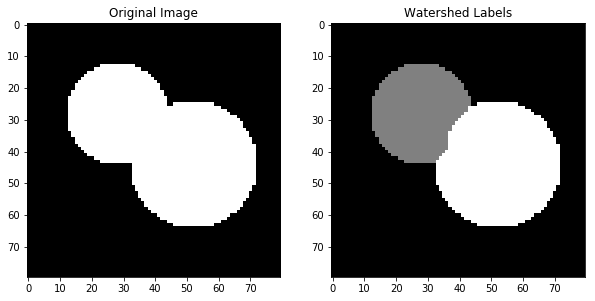

In [46]:
# Create an image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Run the distance transformation and seeding
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(image)
from skimage.feature import peak_local_max
local_maxi = peak_local_max(distance, labels=image, footprint=np.ones((3, 3)), indices=False)
markers = ndi.label(local_maxi)[0]

# Run the watershed transform
labels = watershed(-distance, markers, mask=image)
#labels = watershed(-distance, markers)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(image, interpolation='none', cmap='gray')
ax[1].imshow(labels, interpolation='none', cmap='gray')
ax[0].set_title('Original Image')
ax[1].set_title('Watershed Labels')
plt.show()

In [ ]:
# Rerun the transform 
#ws = watershed(img_smooth8, seeds_labeled)
#ws = watershed(~img_smooth8, seeds_labeled)
ws = watershed(-img_smooth8, seeds_labeled, mask=mem_final)

# Show the result as transparent overlay over the smoothed input image
plt.figure(figsize=(10,10))
plt.imshow(img_smooth8, interpolation='none', cmap='gray')
plt.imshow(ws, interpolation='none', cmap='prism', alpha=0.9)
plt.show()

## Postprocessing

### Affine Transformations

Affine transformations are, intuitively, transformations of an image that preserve straight lines (so no wavy modifiers) and preserve relative distances along a line (so no stretching out of one half of an image).

Here is an example of a function which can flip an image, which is an affine transformation:

In [ ]:
def flip_axis(x, axis):
  x = np.asarray(x).swapaxes(axis, 0)
  x = x[::-1, ...]
  x = x.swapaxes(0, axis)
  return x

Alternatively, in the case where we are rotating, we define the rotation matrix as follows:

In [ ]:
# Set rotation angle, in radians.
theta = 3.14

rotation_matrix = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

In [ ]:
Feel free to play around with the `scipy.ndimage.affine_transform` command to try out other affine transformations.

## Writing Output to Files

One of Python's strengths is how well-suited it is to every piece of the image processing pipeline. Arguably, one of the most important parts of this pipeline is providing an output. In this section, we will briefly discuss a few ways to write this information to disk.

### Images

Write one or more of the images you produced to a tif file using the `imsave` function from the `skimage.io` module. 

Make sure that the array you are writing is of integer type. If necessary, you can use the method `astype` for conversions - e.g. `some_array.astype(np.uint8)` or `some_array.astype(np.uint16)`. Be careful when converting a segmentation to uint8; if there are more than 255 cells, the 8bit format won't have sufficient bit-depth to represent all of the cell IDs.

You can also try adding the segmentation to the original image, creating an image with two channels, one of them being the segmentation. After writing the file, load it into Fiji and check that everything worked as intended.

In [ ]:
from skimage.io import imsave
imsave("watershedseg.tif", ws.astype(np.uint16))

### NPZ

Another uesful file type is a NumPy file. Numpy files allow fast storage and reloading arrays.  

In [ ]:
# Use the function 'np.save' to save the array and reload it using 'np.load'.
np.save("example_seg", ws)  # Save
seg = np.load("example_seg.npy")  # Load
print(ws.shape, seg.shape)

### JSON

Finally, explore the documation and review another popular file type, [JSON](https://realpython.com/python-json/). Attempt to store and reload the same information from the NPZ example again using JSON.

In [ ]:
import pandas as pd
seg2 = pd.DataFrame(seg).to_json('data.json', orient='split')

import json
with open('example_seg2.txt', 'w') as outfile:
    json.dump(seg2, outfile)